# Numerical simulation

Simple example notebook to load SBML files from the [BioModels](https://www.ebi.ac.uk/biomodels/) website, convert them to jax modules, and run the simulation (with the provided initial conditions).

## Imports and Utils

In [1]:
import importlib

import jax
jax.config.update("jax_platform_name", "cpu")

import matplotlib.pyplot as plt
from sbmltoodejax.biomodels_api import get_content_for_model
from sbmltoodejax.modulegeneration import GenerateModel
from sbmltoodejax.parse import ParseSBMLFile

In [2]:
def generate_model(model_idx, deltaT=0.1, atol=1e-6, rtol=1e-12):
    model_fp = "jax_model.py"
    model_xml_body = get_content_for_model(model_idx)
    model_data = ParseSBMLFile(model_xml_body)
    GenerateModel(model_data, model_fp, deltaT=deltaT, atol=atol, rtol=rtol)
    
    return model_fp

def load_model(model_idx, deltaT=0.1, atol=1e-6, rtol=1e-12):
    model_fp = generate_model(model_idx, deltaT=deltaT, atol=atol, rtol=rtol)
    spec = importlib.util.spec_from_file_location("JaxModelSpec", model_fp)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    model_cls = getattr(module, "ModelRollout")

    return model_cls()

## Examples

In this tutorial, we'll see how to easily reproduce the numerical simulation results for:
* the biomodel #10 which was proposed by Kholodenko and models the [Negative feedback and ultrasensitivity can bring about oscillations in the mitogen-activated protein kinase cascades](https://pubmed.ncbi.nlm.nih.gov/10712587/) 
* the biomodel #84 which was proposed by Hornberg et al. and models the [Principles behind the multifarious control of signal transduction - ERK phosphorylation and kinase/phosphatase control](https://pubmed.ncbi.nlm.nih.gov/15634347/).

### Kholodenko2000 - Ultrasensitivity and negative feedback bring oscillations in MAPK cascade

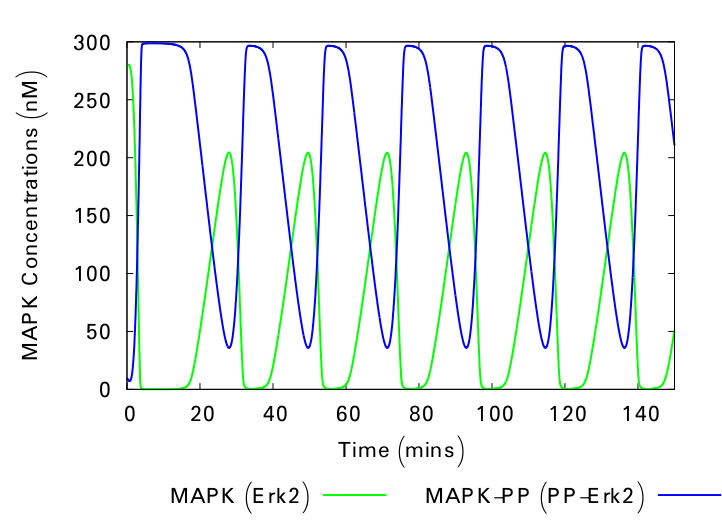

Taken from https://www.ebi.ac.uk/biomodels/BIOMD0000000010#Curation

In [3]:
model = load_model(10)
n_secs = 150*60
ys, ws, times = model(int(n_secs / model.deltaT))

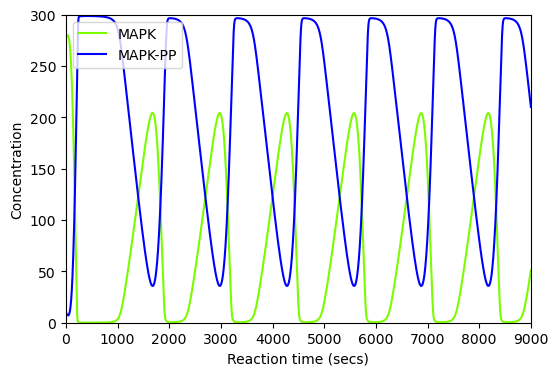

In [4]:
plt.figure(figsize=(6, 4))
plt.plot(times, ys[model.modelstepfunc.y_indexes["MAPK"]], color="lawngreen", label="MAPK")
plt.plot(times, ys[model.modelstepfunc.y_indexes["MAPK_PP"]], color="blue", label="MAPK-PP")
plt.xlim([0,150*60])
plt.ylim([0,300])
plt.xlabel("Reaction time (secs)")
plt.ylabel("Concentration")
plt.legend()
plt.show()

### Hornberg2005_ERKcascade

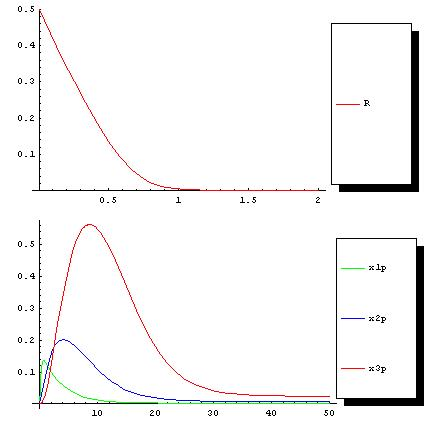

From https://www.ebi.ac.uk/biomodels/BIOMD0000000084#Curation

In [5]:
model = load_model(84)
n_secs = 50
ys, ws, times = model(int(n_secs / model.deltaT))

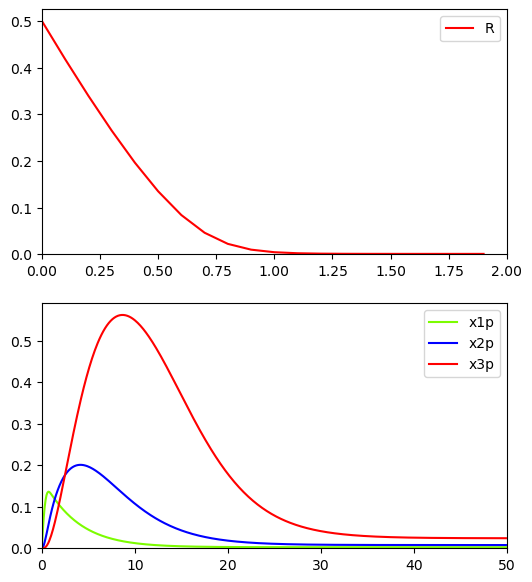

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(6, 7))
ax[0].plot(
    times[: int(2 / model.deltaT)],
    ys[model.modelstepfunc.y_indexes["R"], : int(2 / model.deltaT)],
    color="red",
    label="R",
)
ax[0].legend()
ax[0].set_xlim([0.,2])
ax[0].set_ylim(bottom=0)

ax[1].plot(times, ys[model.modelstepfunc.y_indexes["x1p"]], color="lawngreen", label="x1p")
ax[1].plot(times, ys[model.modelstepfunc.y_indexes["x2p"]], color="blue", label="x2p")
ax[1].plot(times, ys[model.modelstepfunc.y_indexes["x3p"]], color="red", label="x3p")
ax[1].legend()
ax[1].set_xlim([0.,50])
ax[1].set_ylim(bottom=0)

plt.show()

## Error Cases

Note that SBMLtoODEjax does not (yet) handles the numerical simulation of all models present on the BioModels website, or more generally it does not handle all possible SBML files. 
We detail below the error types we have over the 1048 provided (curated) models:

<img src="../_static/error_cases.png" alt="conversion_simulation_success_rate" style="width: 600px;"/>